In [1]:
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette()

from numba import jit, prange
import logging
logging.basicConfig(level=logging.INFO)

sns.set_style("ticks")
sns.set_context("talk")

In [3]:
def initialize_system(N):
    """
    Initialize the system with random spins
    """

    # Initialize the spins randomly, slight bias for more stability
    spins = np.random.choice([-1, 1], size=(N, N), p=[0.2, 0.8])

    # Zero padding to avoid boundary checks
    S = np.zeros((N + 2, N + 2))

    # Set the interior to the random spins
    S[1:-1, 1:-1] = spins

    return S


@jit(nopython=True)
def calculate_energy(S):
    """
    Calculate the energy of the system
    """

    return -np.sum(S[1:, :] * S[:-1, :]) - np.sum(S[:, 1:] * S[:, :-1])


@jit(nopython=True)
def calculate_magnetization(S):
    """
    Calculate the magnetization of the system
    """

    return np.sum(S)


@jit(nopython=True)
def update_system(S, T):
    """
    Update the system using the Metropolis algorithm
    """

    # Calculate the inverse temperature
    beta = 1 / T

    # Calculate the initial energy
    energy_S = calculate_energy(S)

    # Perform NxN updates, shapes -2 to exclude the padding
    for _ in range(S.shape[0] - 2):

        for _ in range(S.shape[1] - 2):
            
            # Randomly select a spin, excluding the padding
            i = np.random.randint(1, S.shape[0] - 1)
            j = np.random.randint(1, S.shape[1] - 1)

            # Calculate the change in energy
            dE = 2 * S[i, j] * (S[i - 1, j] + S[i + 1, j] + S[i, j - 1] + S[i, j + 1])

            # Flip the spin if the energy change is favorable or with a probability
            if dE < 0 or np.random.rand() < np.exp(-beta * dE):

                # Flip the spin
                S[i, j] *= -1

                # Update the energy
                energy_S += dE

    return S, energy_S


@jit(nopython=True, parallel=True)
def simulate(S_initial, Ts, N_samples, N_wait):
    """
    Simulate the Ising model using the Metropolis algorithm for a range of temperatures
    """

    # Initialize the arrays to store the energies and magnetizations
    energies = np.zeros((len(Ts), N_samples))
    magnetizations = np.zeros((len(Ts), N_samples))

    # Parallelized loop over the temperatures
    for i in prange(Ts.shape[0]):
        T = Ts[i]
        S = S_initial.copy()

        # Perform N_wait updates to reach equilibrium
        for _ in range(N_wait):
            S, _ = update_system(S, T)

        # Perform N_samples updates to take measurements
        for j in range(N_samples):
            
            # Perform a Metropolis update
            S, energy = update_system(S, T)

            # Store the energy and magnetization
            energies[i, j] = energy
            magnetizations[i, j] = calculate_magnetization(S)

    return energies, magnetizations

In [9]:
# Define the temperatures to simulate
Ts = np.arange(0.2, 4.2, 0.2)

# Define the critical temperature
T_C = 2 / np.log(1 + np.sqrt(2))

# Fill storage dictionary for different N and N_samples for later use
dict_storage = {}

# Loop over the system sizes
for N in [10, 50, 100]:
    logging.info(f"N = {N}")
    
    # Initialize the system of size N
    S_initial = initialize_system(N)
    
    # Loop over the number of samples
    for N_samples in [1000, 10000]:
        logging.info(f"N_samples = {N_samples}")

        # Number of updates to wait for equilibrium
        N_wait = 10**4

        # Thermalize the system and take N_samples measurements
        energies, magnetizations = simulate(S_initial, Ts, N_samples, N_wait)

        # Calculate the observables
        U = np.mean(energies, axis=1)
        C_V = np.var(energies, axis=1) / Ts**2
        M = np.mean(magnetizations, axis=1)

        # Store the observables
        dict_N_N_samples = {"U": U, "C_V": C_V, "M": M}
        dict_storage.update({(N, N_samples): dict_N_N_samples})

INFO:root:N = 10
INFO:root:N_samples = 1000
INFO:root:N_samples = 10000
INFO:root:N = 50
INFO:root:N_samples = 1000
INFO:root:N_samples = 10000
INFO:root:N = 100
INFO:root:N_samples = 1000
INFO:root:N_samples = 10000


In [10]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

color_dict = {10: colors[0], 50: colors[1], 100: colors[2]}
marker_dict = {1000: "o", 10000: "x"}

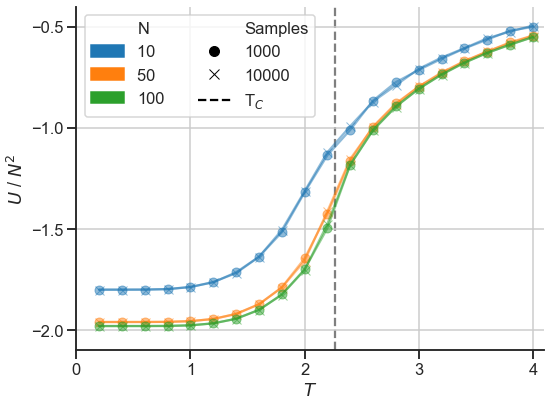

In [11]:
# Plot the energy as a function of temperature

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for key, value in dict_storage.items():
    N, N_samples = key
    U = value["U"]

    ax.plot(Ts, U / N**2, color=color_dict[N], marker=marker_dict[N_samples], alpha=0.5)

ax.axvline(T_C, color="k", linestyle="--", alpha=0.5, zorder=0)
ax.set_xlabel(r"$T$")
ax.set_ylabel(r"$U$ / $N^2$")

ax.set_xticks(np.arange(0, 4.5, 1))
ax.set_xlim(0., 4.1)

ax.set_yticks(np.arange(-2, 0, 0.5))
ax.set_ylim(-2.1, -0.4)

# Custom legend
color_handles = [Patch(color=color_dict[key], label=f"{key:<3d}") for key in color_dict.keys()]
marker_handles = [Line2D([], [], linestyle='', marker=marker_dict[key], color='black', markersize=10, label=f"{key}") for key in marker_dict.keys()]
T_C_handle = [Line2D([], [], linestyle='--', color='black', label=r"T$_C$")]

N_title_handle = [Line2D([], [], linestyle='', label=r"N")]
N_samples_title_handle = [Line2D([], [], linestyle='', label=r"Samples")]
plt.legend(handles=N_title_handle + color_handles + N_samples_title_handle + marker_handles + T_C_handle, ncol=2, title="")

ax.grid()

plt.tight_layout()
sns.despine()
plt.show()

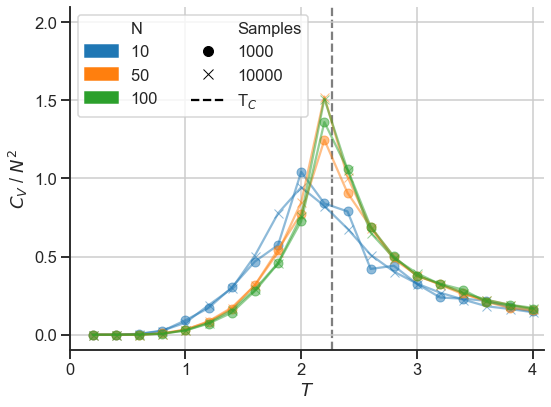

In [12]:
# Plot the heat capacity as a function of temperature

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for key, value in dict_storage.items():
    N, N_samples = key
    C_V = value["C_V"]

    ax.plot(Ts, C_V / N**2, color=color_dict[N], marker=marker_dict[N_samples], alpha=0.5)

ax.axvline(T_C, color="k", linestyle="--", alpha=0.5, zorder=0)
ax.set_xlabel(r"$T$")
ax.set_ylabel(r"$C_V$ / $N^2$")

ax.set_xticks(np.arange(0, 4.5, 1))
ax.set_xlim(0., 4.1)

ax.set_yticks(np.arange(0, 2.5, 0.5))
ax.set_ylim(-0.1, 2.1)

# Custom legend
color_handles = [Patch(color=color_dict[key], label=f"{key:<3d}") for key in color_dict.keys()]
marker_handles = [Line2D([], [], linestyle='', marker=marker_dict[key], color='black', markersize=10, label=f"{key}") for key in marker_dict.keys()]
T_C_handle = [Line2D([], [], linestyle='--', color='black', label=r"T$_C$")]

N_title_handle = [Line2D([], [], linestyle='', label=r"N")]
N_samples_title_handle = [Line2D([], [], linestyle='', label=r"Samples")]
plt.legend(handles=N_title_handle + color_handles + N_samples_title_handle + marker_handles + T_C_handle, ncol=2, title="")

ax.grid()

plt.tight_layout()
sns.despine()
plt.show()

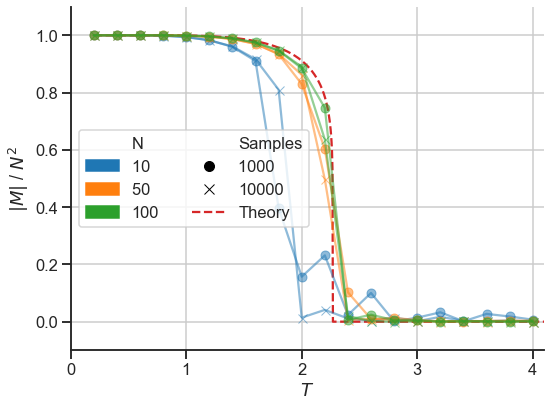

In [13]:
# Plot the magnetization as a function of temperature

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for key, value in dict_storage.items():
    N, N_samples = key
    M = value["M"]

    ax.plot(Ts, np.abs(M / N**2), color=color_dict[N], marker=marker_dict[N_samples], alpha=0.5)

# Theoretical prediction
ts = np.linspace(0.2, 4.2, 1000)
mask = ts < T_C
M_theory = np.hstack([(1 - np.sinh(2 / ts[mask]) ** (-4)) ** (1 / 8), np.zeros_like(ts[~mask])])

plt.plot(ts, M_theory, color=colors[3], linestyle="--", zorder=1, label="Theory")

ax.set_xlabel(r"$T$")
ax.set_ylabel(r"$|M|$ / $N^2$")

ax.set_xticks(np.arange(0, 4.5, 1))
ax.set_xlim(0., 4.1)

ax.set_yticks(np.arange(-1, 1.2, 0.2))
ax.set_ylim(-0.1, 1.1)

# Custom legend
color_handles = [Patch(color=color_dict[key], label=f"{key:<3d}") for key in color_dict.keys()]
marker_handles = [Line2D([], [], linestyle='', marker=marker_dict[key], color='black', markersize=10, label=f"{key:<5d}") for key in marker_dict.keys()]

theory_handle = [Line2D([], [], linestyle='--', color=colors[3], label="Theory")]
empty_handle = [Line2D([], [], linestyle='', label="")]

N_title_handle = [Line2D([], [], linestyle='', label=r"N")]
N_samples_title_handle = [Line2D([], [], linestyle='', label=r"Samples")]
plt.legend(handles=N_title_handle + color_handles + N_samples_title_handle + marker_handles + theory_handle, ncol=2, title="")

ax.grid()

plt.tight_layout()
sns.despine()
plt.show()